#  <center> Variational auto-encoders (VAEs) <center>

## Discovery of novel molecules with VAEs from SMILES strings

In [3]:
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
import torch.nn.functional as F
import pandas as pd
from rdkit import Chem
from sklearn.preprocessing import LabelEncoder
import random
from tqdm import tqdm

from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*')

In [4]:
# Get data 
! wget https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps4/data/zinc_50k.csv
    
# Get pretrained VAE model 
! wget -O vae_checkpoint.pth https://github.com/wwang2/ML4MolEng/blob/master/psets/ps4/pretrained_checkpoints/vae-050-0.06.pth?raw=true

--2021-04-28 03:23:21--  https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps4/data/zinc_50k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2504809 (2.4M) [text/plain]
Saving to: ‘zinc_50k.csv’

zinc_50k.csv        100%[===================>]   2.39M  --.-KB/s    in 0.03s   

2021-04-28 03:23:21 (70.0 MB/s) - ‘zinc_50k.csv’ saved [2504809/2504809]

--2021-04-28 03:23:21--  https://github.com/wwang2/ML4MolEng/blob/master/psets/ps4/pretrained_checkpoints/vae-050-0.06.pth?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wwang2/ML4MolEng/raw/master/psets/ps4/pretrained_checkpoints/vae-050

### 1.1 One-hot encode SMILES strings into padded numerical vectors

In [5]:
from sklearn import preprocessing

# Character list for SMILES string
moses_charset = ['2', 'o', 'C', 'I', 'O', 'H', 'n', 'N', '=', '+', '#', '-', 'c',
                 'B', 'l', '7', 'r', 'S', 's', '4', '6', '[', '5', ']', 'F', '3', 
                 'P', '(', ')', '1', ' ']

# Define encoder 
enc = preprocessing.LabelEncoder().fit(moses_charset)

# Read data 
df = pd.read_csv("./zinc_50k.csv")

print(df['SMILES'].tolist())


['O=S(=O)(Nc1ccc(F)c(Cl)c1)c1cccc(O)c1', 'Cc1nc(C2(NC(=O)C(C)OC3CCCCCC3)CCCC2)no1', 'O=C(NCCNC(=O)N1CCc2ccccc2C1)c1ccn[nH]1', 'O=C(NCC1CCC1)c1nc(OCC2CC2)ccc1Cl', 'CS(=O)c1ccc(C(=O)N(C2CCCCC2)C2CC2)cc1', 'COc1ccccc1-n1nnnc1SCC(=O)Nc1cc(C)on1', 'CC1Cc2ccccc2N1C(=O)COC(=O)c1cccc2ncccc12', 'COC1CC2CC1CN2C(=O)Cc1cccc(F)c1', 'O=C(c1cccnc1Oc1ccccc1)N1CCCC1', 'Cc1ccc(-c2noc(CCNc3nccc(C)n3)n2)cc1', 'CCN(CCO)S(=O)(=O)c1ccc(Cl)cc1F', 'Cc1ccc(NC(=O)CC(C#N)c2ccncc2)cc1Cl', 'O=C(N1CCCOC(Cn2cccn2)C1)C1(c2ccc(F)cc2)CC1', 'Cc1sc(=O)n(CC(=O)NCC(C(C)C)N2CCOCC2)c1C', 'CC(Cc1nc2ccccc2s1)NC(=O)Nc1ccccn1', 'COc1ccc(C)cc1CS(=O)(=O)c1ccc(O)cc1', 'O=C1c2ccccc2NC(c2ccsc2)N1c1ccncc1', 'O=C(c1cnc(C2CC2)nc1)N1CCC(Cc2ccc(F)cc2)CC1', 'Cn1c(=O)c2c(ncn2CCC(=O)NCC2CCCCC2)n(C)c1=O', 'CCc1cc(=O)n2c(n1)SCC2CC(=O)N1CC(C)CC(C)C1', 'Cc1ccc(C(=O)NC(C(N)=O)c2ccccc2)c(=O)[nH]1', 'CCc1ncc(C(=O)NCCCn2cc(Cl)cn2)cn1', 'CCCn1ncc2cc(C(=O)Nc3ccccc3C)c(N)nc21', 'Cc1ccc(N2CC3(CCN(C(=O)c4cccnc4)C3)C2)nn1', 'Nc1c(Cl)cccc1C(=O)OCC(=O)NCc1cc

Encode SMILES string into padded categorial vectors 

In [7]:

data = df['SMILES'].tolist()

just_len = len( max(data, key=len) )

labeled_data = []

for smiles in data:
  # split smiles to list of chars + padding
  string = list(smiles.ljust(just_len, ' '))
  # label encode into list of ints
  enc_item = enc.transform(string)
  labeled_data.append(enc_item)

SMILES_len = len( max(labeled_data, key=len) )


Make train/validation/test datasets

In [8]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# convert encoded SMILES to LongTensor
X_data = torch.LongTensor(labeled_data)

# Split dataset to train/val/test ( Ratios: 0.8*0.875=0.7 / 0.8*0.125=0.1 / 0.2 )
X, X_test = train_test_split(X_data, test_size=0.2)
X_train, X_val = train_test_split(X, test_size=0.125)

#Build dataset 
traindata = TensorDataset(X_train)
valdata = TensorDataset(X_val)
testdata = TensorDataset(X_test)

# Build dataloader
batchsize = 512
train_loader = DataLoader(dataset=traindata, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(dataset=valdata, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(dataset=testdata, batch_size=batchsize, shuffle=True)


### 1.2 Implement the reparametrization trick for VAE



In [9]:
# Molecular VAE model 

class MolVAE(nn.Module):
    def __init__(self,  rnn_enc_hid_dim, enc_nconv,
                         encoder_hid, z_dim, 
                         rnn_dec_hid_dim, dec_nconv, smiles_len, nchar
                         ):
        '''
            SMILES VAE model 
            
                rnn_enc_hid_dim: hidden dimension for the GRU encoder 
                enc_nconv: number of recurrent layers for the GRU decoder
                encoder_hid: dimension of GUR encoder readout
                z_dim: number of latent variable 
                rnn_dec_hid_dim: hidden dimension for the GRU decoder 
                dec_nconv: number of recurrent layers for the GRU decoder
                smiles_len: total length of padded SMILES string 
                nchar: number of possible characters 
                
        '''
        
        super(MolVAE, self).__init__()
        
        self.smiles_len = smiles_len
        self.nchar = nchar
        # Embedding layer
        self.embed = nn.Embedding(self.nchar, rnn_enc_hid_dim)
        # Encoding GRU
        self.rnn_enc = nn.GRU(rnn_enc_hid_dim, rnn_enc_hid_dim, enc_nconv, batch_first=True)
        # MLP to transfrom hidden output from Encoding GRU
        self.mlp0 = nn.Linear(rnn_enc_hid_dim, encoder_hid)
        # Network to parametrize mu
        self.mu_network = nn.Linear(encoder_hid, z_dim)
        # Network to parametrize log variance
        self.logvar_network = nn.Linear(encoder_hid, z_dim)
        # Decoding GRU
        self.rnn_dec = nn.GRU(z_dim, rnn_dec_hid_dim, dec_nconv, batch_first=True)
        # Output SMILES characters
        self.readout = nn.Linear(rnn_dec_hid_dim, self.nchar)

    def encode(self, x):
        '''output mean and logVariance of the encoded SMILES'''
        output, hn = self.rnn_enc(x)
        h = F.relu(self.mlp0(hn[-1]))
        return self.mu_network(h), self.logvar_network(h)
    
    def get_std(self, logvar):
        '''transfrom log variance to standard deviation'''
        std = torch.exp(0.5*logvar)
        return std

    def reparametrize(self, mu, std):
        '''the reparametrization trick'''
        if self.training:
            eps = torch.randn_like(mu)
            z = mu + eps*std
            return z
        else:
            return mu

    def decode(self, z):
        '''decoder to reconstruct latent variable back to SMILES'''
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.smiles_len, 1)
        out, h = self.rnn_dec(z)
        out_reshape = out.contiguous().view(-1, out.size(-1))
        
        y0 = self.readout(out_reshape)
        y = y0.contiguous().view(out.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        x_embed = self.embed(x) # Get SMILES embedding 
        mu, logvar = self.encode(x_embed) # Encoding SMILES to latent representations 
        std = self.get_std(logvar) # tranfrom log variance to std.
        z = self.reparametrize(mu, std) # reparametrization trick 
        smiles_recon = self.decode(z)  # reconstruct SMILES string 
        return smiles_recon, mu, std

Sample a 1d Gaussian distribution with mean 0, std = 1

In [10]:

SMILES_len = len( max(labeled_data, key=len) )
device = 'cuda:0'

test = MolVAE(rnn_enc_hid_dim=128, enc_nconv=2, encoder_hid=256, z_dim=32,
              rnn_dec_hid_dim=128, dec_nconv=2, nchar=len(moses_charset), smiles_len=SMILES_len)

mu_test = torch.zeros(1000,1)
var_test = torch.ones(1000,1)
sample = test.reparametrize(mu_test, var_test)


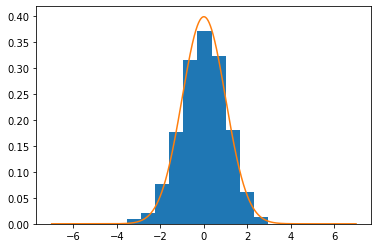

In [11]:
# Compare your sampling with N(0, 1)

import matplotlib.pyplot as plt
from scipy.stats import norm

plt.hist(sample.detach().cpu().numpy(), density=True)

# Plot a 1d unit Gaussian 
x_axis = np.arange(-7, 7, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,1)) # Mean = 0, SD = 1.
plt.show()


### 1.3 Implement the SMILES VAE loss function

In [12]:
def loss_function(recon_x, x, mu, std):
    recon_x_T = recon_x.transpose(1,2)
    # reconstruction loss 
    L_recon = F.cross_entropy(recon_x_T, x)
    # KL loss
    var = pow(std,2)
    L_kl = torch.mean( 0.5*torch.sum( var + pow(mu,2) - torch.log(var) - 1, 1), 0)
    return L_recon, L_kl

In [13]:
# Helper functions 
def index2smiles(mol_index, enc):
    '''Transform Your An array of character index back to SMILES'''
    smiles_charlist = enc.inverse_transform(mol_index)
    smiles = ''.join(smiles_charlist).strip(" ")
    
    return smiles

def check_smiles_valid(smiles):
    '''Check if SMILES string is valid'''
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        valid = True 
    else:
        valid = False 
    return valid

def sample_recon(model, epoch, dataloader, enc, n_sample=500):
    '''Randomly sample from data loader to get reconstructed SMILES and test if it is valid'''
    # evaluation mode 
    model.eval()
    
    # Randomly select samples 
    random_mol = random.choices( range( len(dataloader.dataset) ), k=n_sample)
    x_mol = train_loader.dataset.__getitem__(random_mol)[0]
    x_mol = x_mol.to(device)
    
    # Get reconstructed Molecule 
    mol_recon, mu, logvar = model(x_mol)
    mol_index = mol_recon.detach().cpu().numpy().argmax(-1).squeeze()
    mol_orig = x_mol.detach().cpu().numpy()
    
    # Show the first reconstructed SMILES
    print("epoch {} sample orig SMILES: {}".format(epoch,  index2smiles(mol_orig[0], enc)))
    print("epoch {} sample recon SMILES: {}".format(epoch,  index2smiles(mol_index[0], enc)))
    
    valid_count = 0 
    for indexed_smiles in mol_index:
        smiles = index2smiles(indexed_smiles, enc)
        valid = check_smiles_valid(smiles)
        
        if valid: 
            valid_count += 1
    
    print("{}/{} SMILES are valid".format(valid_count, n_sample))

def loop(model, loader, epoch, beta=0.05, evaluation=False):
    '''
        Train/test VAE model
    '''
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
        
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    for data in tqdm_data:
        
        x = data[0].to(device)
        recon_batch, mu, std = model(x)
        loss_recon, loss_kl = loss_function(recon_batch, x, mu, std)
        loss = loss_recon + beta * loss_kl     
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['recon loss={:.3f}'.format(loss_recon.item()) ,
                   'KL loss={:.3f}'.format(loss_kl.item()) ,
                   'total loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

### 1.4  Train VAE

In [14]:
device = 'cuda:0'

model = MolVAE(rnn_enc_hid_dim=367, enc_nconv=2, encoder_hid=512, z_dim=171,
               rnn_dec_hid_dim=512, dec_nconv=1, nchar=len(moses_charset), smiles_len=SMILES_len)
                      
model = model.to(device)

# load pretrained model 
model.load_state_dict(torch.load("./vae_checkpoint.pth"))


<All keys matched successfully>

In [15]:
optimizer = optim.Adam(model.parameters(),lr=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

In [16]:
epochs = 50

beta=0.001

for epoch in range(0, epochs):
    
    sample_recon(model, epoch, val_loader, enc)
    train_loss = loop(model, train_loader, epoch, beta)
    val_loss = loop(model, val_loader, epoch, beta, evaluation=True)
    scheduler.step(val_loss)
    
    # optional: save model 
    if epoch % 15 == 0:
         torch.save(model.state_dict(), 
                    '/{}/hw4_p2/vae-{:03d}-{:.2f}.pth'.format(mydrive, epoch, train_loss))
        
         torch.save(optimizer.state_dict(),
             '/{}/hw4_p2/optim-{:03d}-{:.2f}.pth'.format(mydrive, epoch, train_loss))

    if epoch == 0:
        best_loss = train_loss.item()
    else:
        if train_loss.item() < best_loss:
            best_loss = train_loss.item()


train (epoch #0):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 0 sample orig SMILES: COc1cc(CNc2ncccc2C#N)ccc1O
epoch 0 sample recon SMILES: COc1cc(CNc2ncccc2C##N)ccc1O
133/500 SMILES are valid


train (epoch #1):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 1 sample orig SMILES: Cc1ccc(Cl)cc1S(=O)(=O)NCc1cscn1
epoch 1 sample recon SMILES: Cc1ccc(Cl)cc1S(=O)(=O)NCc1cscn1
424/500 SMILES are valid


train (epoch #2):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 2 sample orig SMILES: Cc1cccn2cc(CC(=O)Nc3cccnc3N3CCCC3)nc12
epoch 2 sample recon SMILES: Cc1cccc2cc(CC(=O)Nc3cccnc3N3CCCC3)nc12
437/500 SMILES are valid


train (epoch #3):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 3 sample orig SMILES: Cc1[nH]c(=O)[nH]c(=O)c1CC(=O)Nc1ccc2c(c1)NC(=O)C(C)O2
epoch 3 sample recon SMILES: Cc1cnH]c(=O)[nH]c(=Occ1CCC(=O)c1ccccc(cc1CCOO)C(C)C
441/500 SMILES are valid


train (epoch #4):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 4 sample orig SMILES: COc1cc(C#N)ccc1OCC(=O)NCc1cccc(Cl)c1
epoch 4 sample recon SMILES: COc1cc(C#N)ccc1OCC(=O)NCc1cccc(Cl)c1
444/500 SMILES are valid


train (epoch #5):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 5 sample orig SMILES: Cc1nn(C)c(C)c1CCNC(=O)NC1CCCCC1
epoch 5 sample recon SMILES: Cc1nn(C)c(C)c1CCNC(=O)NC1CCCCC1
439/500 SMILES are valid


train (epoch #6):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 6 sample orig SMILES: Cc1ccc(NC(=O)N(C)CC(=O)N2CCOCC2)cc1Cl
epoch 6 sample recon SMILES: Cc1ccc(NC(=O)N(C)CC(=O)N2CCOCC2)cc1Cl
426/500 SMILES are valid


train (epoch #7):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 7 sample orig SMILES: CCc1nnsc1C(=O)NCc1ccnc(-n2cccn2)c1
epoch 7 sample recon SMILES: CCc1nnsc1C(=O)NCc1ccnc(-n2cccn2)c1
431/500 SMILES are valid


train (epoch #8):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 8 sample orig SMILES: CC(C)n1nnnc1-c1cccc(C(=O)Nc2ccc(C#N)cc2)c1
epoch 8 sample recon SMILES: CC(C)n1nnnc1-c1cccc(C(=O)Nc2ccc(C#N)cc2)c1
438/500 SMILES are valid


train (epoch #9):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 9 sample orig SMILES: O=C1CC(Nc2ccc3nccnc3n2)CN1c1ccccc1
epoch 9 sample recon SMILES: O=C1CC(Nc2ccc3ncccc3n2)CN1c1ccccc1
432/500 SMILES are valid


train (epoch #10):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 10 sample orig SMILES: CC(C)COC(=O)c1ccc(Cl)c(S(=O)(=O)N(C)C)c1
epoch 10 sample recon SMILES: CC(C)COC(=O)c1ccc(Cl)c(S(=O)(=O)N(C)C)c1
443/500 SMILES are valid


train (epoch #11):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 11 sample orig SMILES: O=C(CCn1cncn1)N1CC2(CCCC2)c2ccccc21
epoch 11 sample recon SMILES: O=C(CCn1cncn1)N1CC2(CCCC2)c2ccccc21
433/500 SMILES are valid


train (epoch #12):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 12 sample orig SMILES: COC1CCC(OC(=O)c2cnc(C3CCCO3)s2)CC1
epoch 12 sample recon SMILES: COC1CCC(OC(=O)c2cnc(C3CCCO3)s2)CC1
447/500 SMILES are valid


train (epoch #13):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 13 sample orig SMILES: O=C1Cc2cc(-c3ccc(-c4ccn[nH]4)cc3)ccc2N1
epoch 13 sample recon SMILES: O=C1Cc2cc(-c3ccc(-c4ccn[nH]4)cc3)ccc2N1
442/500 SMILES are valid


train (epoch #14):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 14 sample orig SMILES: Cc1ccccc1C(C#N)N(C)S(=O)(=O)c1ccccc1C
epoch 14 sample recon SMILES: Cc1ccccc1C(C#N)N(C)S(=O)(=O)c1ccccc1C
435/500 SMILES are valid


train (epoch #15):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 15 sample orig SMILES: COCCCNC(=O)N1CCC(NC(=O)C2CC2)CC1
epoch 15 sample recon SMILES: COCCCNC(=O)N1CCC(NC(=O)C2CC2)CC1
440/500 SMILES are valid


train (epoch #16):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 16 sample orig SMILES: CC1CCC(NC(=O)c2cn(C)nc2C(C)(C)C)CC1
epoch 16 sample recon SMILES: CC1CCC(NC(=O)c2cn(C)nc2C(C)(C)C)CC1
448/500 SMILES are valid


train (epoch #17):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 17 sample orig SMILES: Cc1ccc2cc(C(=O)N(C)Cc3cc(C)on3)[nH]c2c1
epoch 17 sample recon SMILES: Cc1ccc2cc(C(=O)N(C)Cc3cc(C)on3)[nH]c2c1
445/500 SMILES are valid


train (epoch #18):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 18 sample orig SMILES: Fc1ccccc1-c1nn(-c2nccs2)c2c1CNCC2
epoch 18 sample recon SMILES: Fc1ccccc1-c1nn(-c2ncns2)c2c1CCCC2
454/500 SMILES are valid


train (epoch #19):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 19 sample orig SMILES: CCOc1ncccc1CNC(=O)C(C)NC(C)=O
epoch 19 sample recon SMILES: CCOc1ncccc1CNC(=O)C(C)NC(C)=O
446/500 SMILES are valid


train (epoch #20):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 20 sample orig SMILES: CCCn1cnc2cc(NC(=O)NCCN3CCCOC3=O)ccc21
epoch 20 sample recon SMILES: CCCn1cnc2cc(NC(=O)NCCN3CCCCC3=O)ccc21
446/500 SMILES are valid


train (epoch #21):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 21 sample orig SMILES: Cn1cccc1C(=O)N1CCc2onc(CN3CCOCC3)c2C1
epoch 21 sample recon SMILES: Cn1cccc1C(=O)N1CCc2nnc(CN3CCOCC3)c2C1
426/500 SMILES are valid


train (epoch #22):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 22 sample orig SMILES: Cc1cnc(N2CCC3(CCCN(c4ncc(F)cn4)C3)C2)nc1
epoch 22 sample recon SMILES: Cc1cnc(N2CCC3(CCCN(c4ncc(F)cn4)C3)C2)nc1
443/500 SMILES are valid


train (epoch #23):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 23 sample orig SMILES: Cc1nc(-c2cc(C(=O)Nc3cccc(C)c3C)n(C)c2)cs1
epoch 23 sample recon SMILES: Cc1nc(-c2cc(C(=O)Nc3cccc(C)c3C)n(C)c2)cs1
452/500 SMILES are valid


train (epoch #24):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 24 sample orig SMILES: CC(C)(CNCc1ccc(F)cc1)N1CCOCC1
epoch 24 sample recon SMILES: CC(C)(CNCc1ccc(F)cc1)N1CCOCC1
439/500 SMILES are valid


train (epoch #25):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 25 sample orig SMILES: Cc1ccc(NC(=O)CCc2nc(-c3ccncc3)no2)c(Cl)c1
epoch 25 sample recon SMILES: Cc1ccc(NC(=O)CCc2nc(-c3ccncc3)no2)c(Cl)c1
442/500 SMILES are valid


train (epoch #26):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 26 sample orig SMILES: CCC(C)(C)NC(=O)Cn1cnc(C2CCC2)cc1=O
epoch 26 sample recon SMILES: CCC(C)(C)NC(=O)Cn1cnc(C2CCC2)cc1=O
442/500 SMILES are valid


train (epoch #27):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 27 sample orig SMILES: Cc1csc(CCNC(=O)c2cc(N)cn2C)n1
epoch 27 sample recon SMILES: Cc1csc(CCNC(=O)c2cc(N)cn2C)n1
453/500 SMILES are valid


train (epoch #28):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 28 sample orig SMILES: Cc1ccccc1C(=O)NCC1(c2cccs2)CCOCC1
epoch 28 sample recon SMILES: Cc1ccccc1C(=O)NCC1(c2cccs2)CCOCC1
450/500 SMILES are valid


train (epoch #29):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 29 sample orig SMILES: CC(C)S(=O)(=O)c1ccc(C(=O)C2CCC2)cc1
epoch 29 sample recon SMILES: CC(C)S(=O)(=O)c1ccc(C(=O)C2CCC2)cc1
440/500 SMILES are valid


train (epoch #30):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 30 sample orig SMILES: CCC(C)NC(=O)c1cccc(Br)c1
epoch 30 sample recon SMILES: CCC(C)NC(=O)c1cccc(Br)c1
450/500 SMILES are valid


train (epoch #31):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 31 sample orig SMILES: COC(=O)CCNC(=O)C1CC(=O)N(C2CCCCCC2)C1
epoch 31 sample recon SMILES: COC(=O)CCNC(=O)C1CC(=O)N(C2CCCCCC2)C1
458/500 SMILES are valid


train (epoch #32):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 32 sample orig SMILES: Cc1noc(C)c1CSc1nnc(-c2ccncc2)o1
epoch 32 sample recon SMILES: Cc1noc(C)c1CSc1nnc(-c2ccncc2)o1
442/500 SMILES are valid


train (epoch #33):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 33 sample orig SMILES: Cc1cccc(C2=CCN(C(=O)c3ccnc(-n4ccnc4)c3)CC2)c1
epoch 33 sample recon SMILES: Cc1cccc(C2=CCN(C(=O)c3ccnc(-n4ccnc4)c3)CC2)c1
444/500 SMILES are valid


train (epoch #34):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 34 sample orig SMILES: NC(=O)CC1CCN(S(=O)(=O)c2ccc(F)c(Cl)c2)CC1
epoch 34 sample recon SMILES: NC(=O)CC1CCN(S(=O)(=O)c2ccc(F)c(Cl)c2)CC1
435/500 SMILES are valid


train (epoch #35):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 35 sample orig SMILES: Cn1cc(CNC(=O)Nc2ccc(F)c(Cl)c2)cn1
epoch 35 sample recon SMILES: Cn1cc(CNC(=O)Nc2ccc(F)c(Cl)c2)cn1
454/500 SMILES are valid


train (epoch #36):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 36 sample orig SMILES: Cc1ccc(O)c(NS(=O)(=O)c2ccccc2C)c1
epoch 36 sample recon SMILES: Cc1ccc(O)c(NS(=O)(=O)c2ccccc2C)c1
443/500 SMILES are valid


train (epoch #37):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 37 sample orig SMILES: CN(C)C(=O)c1ccc(Cl)c(NCc2noc(-c3ccoc3)n2)c1
epoch 37 sample recon SMILES: CN(C)C(=O)c1ccc(Cl)c(NCc2ncc(-c3ccocc)n2)c1
456/500 SMILES are valid


train (epoch #38):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 38 sample orig SMILES: O=C1CN(Cc2ccc(C(F)(F)F)cc2)CCN1
epoch 38 sample recon SMILES: O=C1CN(Cc2ccc(C(F)(F)F)cc2)CCN1
449/500 SMILES are valid


train (epoch #39):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 39 sample orig SMILES: Cc1ccc(OCC2CCCN(C(=O)c3cnn(C(C)C)c3)C2)cc1
epoch 39 sample recon SMILES: Cc1ccc(OCC2CCCN(C(=O)c3cnn(C(C)C)c3)C2)cc1
449/500 SMILES are valid


train (epoch #40):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 40 sample orig SMILES: Cc1c(C(=O)NCc2ccncc2)oc2ccc(Br)cc12
epoch 40 sample recon SMILES: Cc1c(C(=O)NCc2ccncc2)oc2ccc(Br)cc12
434/500 SMILES are valid


train (epoch #41):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 41 sample orig SMILES: CCCCn1ncc(-c2ccc3c(c2)OCCO3)c(N)c1=O
epoch 41 sample recon SMILES: CCCCn1ncc(-c2ccc3c(c2)OCCO3)c(N)c1=O
441/500 SMILES are valid


train (epoch #42):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 42 sample orig SMILES: CC(=O)Nc1cccc2c1CCCN2C(C)CC#N
epoch 42 sample recon SMILES: CC(=O)Nc1cccc2c1CCCN2C(C)CC#N
440/500 SMILES are valid


train (epoch #43):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 43 sample orig SMILES: CC(=O)Nc1ccc(O)c(C(=O)NC(C)c2ccc(C)c(F)c2)c1
epoch 43 sample recon SMILES: CC(=O)Nc1ccc(O)c(C(=O)NC(C)c2ccc(C)c(F)c2)c1
454/500 SMILES are valid


train (epoch #44):   0%|          | 0/69 [00:00<?, ?it/s]

Epoch    44: reducing learning rate of group 0 to 2.5000e-05.
epoch 44 sample orig SMILES: Cc1noc(C)c1CN(C)C(=O)c1cnn(Cc2ccccc2)c1
epoch 44 sample recon SMILES: Cc1noc(C)c1CN(C)C(=O)c1cnn(Cc2ccccc2)c1
455/500 SMILES are valid


train (epoch #45):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 45 sample orig SMILES: CCn1nc(C=Cc2ccccc2)nc2c(=O)n(C)c(=O)nc1-2
epoch 45 sample recon SMILES: CCn1nc(C=Cc2ccccc2)nc2c(=O)n(C)c(=O)nc122
443/500 SMILES are valid


train (epoch #46):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 46 sample orig SMILES: O=C(c1ccc(-n2ccnn2)cc1)N1CCC2(CCCC2)CC1
epoch 46 sample recon SMILES: O=C(c1ccc(-n2ccnn2)cc1)N1CCC2(CCCC2)CC1
440/500 SMILES are valid


train (epoch #47):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 47 sample orig SMILES: CC(=O)c1sc(CCNc2cccc(C)c2)nc1C
epoch 47 sample recon SMILES: CC(=O)c1sc(CCNc2cccc(C)c2)nc1C
459/500 SMILES are valid


train (epoch #48):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 48 sample orig SMILES: Cc1cccc(NC(=O)CCn2cnc3c(cnn3C)c2=O)c1C
epoch 48 sample recon SMILES: Cc1cccc(NC(=O)CCn2cnc3c(cnn3C)c2=O)c1C
450/500 SMILES are valid


train (epoch #49):   0%|          | 0/69 [00:00<?, ?it/s]

epoch 49 sample orig SMILES: CC(C)C(NC(=O)Nc1ccccc1)C(=O)NCCCO
epoch 49 sample recon SMILES: CC(C)C(NC(=O)Nc1ccccc1)C(=O)NCCCO
453/500 SMILES are valid


eval (epoch #49): 100%|██████████| 10/10 [00:00<00:00, 20.78it/s, recon loss=0.023 KL loss=109.506 total loss=0.133 avg. loss=0.131]


### 1.5 Sample new molecules 

In [33]:

#subset_indices = [0, 100] # select your indices here as a list
#subset = torch.utils.data.Subset(testdata, subset_indices)
#test_loader_subset = DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

import random

for test_smiles in test_loader:  
    batch_sample = test_smiles[0]

#samples = random.sample(set(batch_sample), 2)
#enc_samples = model.encode(samples[0])

model.eval()

# Randomly select samples 
random_mol = random.choices( range( len(test_loader) ), k=2)
x_mol = test_loader.dataset.__getitem__(random_mol)[0]
x_mol = x_mol.to(device)
    
# Encode sampled molecule to latent space, z
x_embed = model.embed(x_mol) # Get SMILES embedding 
mu, logvar = model.encode(x_embed) # Encoding SMILES to latent representations 
std = model.get_std(logvar) # tranfrom log variance to std.
z = model.reparametrize(mu, std) # reparametrization trick 

z_novel = []

for weight in np.linspace(0.05,0.95,10):

  z_sample = torch.lerp(z[0], z[1], weight)
  z_novel.append(z_sample)

z_novel = torch.stack(z_novel)

# Decode novel z back to categorical values
novel_mol_recon = model.decode(z_novel)  # reconstruct SMILES string

novel_mol_index = novel_mol_recon.detach().cpu().numpy().argmax(-1).squeeze()

valid_count = 0

smiles_to_check = []
valid_smiles = []

for indexed_smiles in novel_mol_index:
  smiles = index2smiles(indexed_smiles, enc)
  valid = check_smiles_valid(smiles)
  smiles_to_check.append(smiles)

  if valid: 
    valid_count += 1
    valid_smiles.append(smiles)

mol_original = x_mol.detach().cpu().numpy()
smiles_original1 = index2smiles(mol_original[0], enc)
smiles_original2 = index2smiles(mol_original[1], enc)


Visualize molecular line drawings for the molecules.

5/10 novel SMILES are valid
Novel sample recon SMILES:
1: Cc1cnc(-c2cccc(NC(=O)N3CCCC3)c2)o1
2: Cc1cnc(-c2cccc(NC(=O)N3CCC3)c2)o1
3: Ccc1nnc(-c2cccc(C(=O)N(CCC3)c2)o1
4: COc1nnc(Nc2ccccc(C(=O)N(CCC)c2)o1
5: COc1nnc(Cc(=O))c2cc(CC(C)CCC2)11


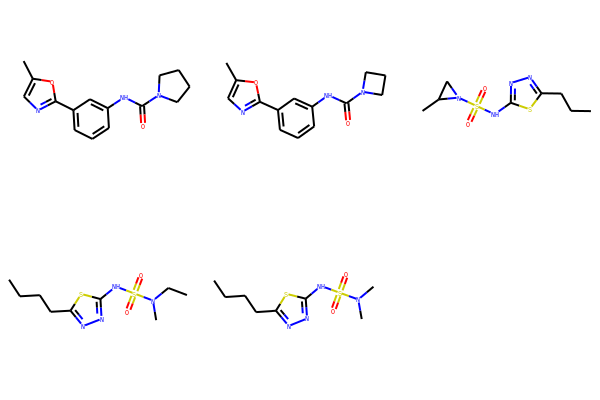

In [34]:

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

original_mol1 = Chem.MolFromSmiles(smiles_original1)
original_mol2 = Chem.MolFromSmiles(smiles_original2)

print("{}/{} novel SMILES are valid".format(valid_count, 10))

novel_mol = []
# Show the first reconstructed SMILES
print("Novel sample recon SMILES:")
for i in range(valid_count):
  print("{}: {}".format(i+1, index2smiles(novel_mol_index[i], enc)))
  novel_mol.append(Chem.MolFromSmiles(valid_smiles[i]))

Draw.MolsToGridImage(novel_mol)

Make Scatter plot

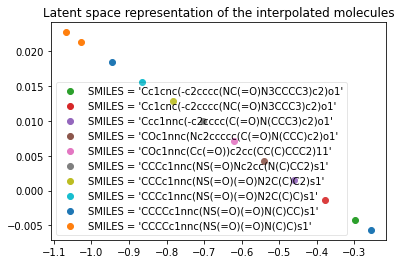

In [69]:

z_plot = z.detach().cpu().numpy()
z_novel_plot = z_novel.detach().cpu().numpy()

plt.scatter(z_plot[0][0], z_plot[0][1])
plt.scatter(z_plot[1][0], z_plot[1][1])

for i in range(10):
  plt.scatter(z_novel_plot[i][0], z_novel_plot[i][1],
              label="SMILES = '{0}'".format(smiles_to_check[i]))

plt.legend(loc="lower left", edgecolor="black", framealpha=0.1)
plt.title("Latent space representation of the interpolated molecules")
plt.show()

Caption: Scatter plot of the first two dimensions of the encoded latent vector of the original molecules (from the test set) and the interpolated molecules encoded in the latent space. Legend shows the SMILES string for the 10 interpolated molecules between the original ones.

Comments:
From the above analysis we have 5/10 valid novel SMILES strings.
In many cases, some of the valid SMILES strings generated by the VAE are duplicates. Additionally, sometimes the interpolation produces valid srings that are identical to the original molecules that we interpolate from (i.e. no novel valid strings exist in the space that we are interpolationg).
This can be attributed to the fact that linear interolation is not an ideal choise of interpolation when the latent space is multi-dimensional (171 vector length). We would have to either interpolate each dimension seperately (here we interpolated all dimensions by a set weight), or sample from another distribution all together.